In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time


In [30]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [31]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [32]:
# Use raw string literals for paths to avoid issues with backslashes
train_dir = r"C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls"
test_dir = r"C:/Users/T8673/Desktop/aircracks_detection/dataset/test/Walls"

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [33]:
print("Class to index mapping:", train_dataset.class_to_idx)

# Print class mapping
print("Class to index mapping:", train_dataset.class_to_idx)

Class to index mapping: {'Cracked': 0, 'Non-cracked': 1}
Class to index mapping: {'Cracked': 0, 'Non-cracked': 1}


In [34]:
 #Corrected: Initialize labels before the loop
labels = train_dataset.targets  # Correct label list for the entire dataset

# Print sample image paths and labels
print("\n--- Sample Training Image Paths and Labels ---")
for i, (path, label) in enumerate(train_dataset.samples):
    if i < 10: # Print only the first 10 samples for brevity
        class_name = train_dataset.classes[label]
        print(f"Image: {path} → Label: {label} ({class_name})")
    else:
        break


--- Sample Training Image Paths and Labels ---
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-101.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-105.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-118.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-119.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-120.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-122.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-128.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/dataset/train/Walls\Cracked\7069-147.jpg → Label: 0 (Cracked)
Image: C:/Users/T8673/Desktop/aircracks_detection/datase

In [35]:
class_count = np.bincount(labels)
print("\nClass counts in training dataset:", class_count)

class_weights = 1. / class_count
sample_weights = [class_weights[l] for l in labels]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

val_labels = test_dataset.targets
val_class_count = np.bincount(val_labels)
val_class_weights = 1. / val_class_count
val_sample_weights = [val_class_weights[l] for l in val_labels]

val_sampler = WeightedRandomSampler(weights=val_sample_weights,
                                    num_samples=len(val_sample_weights),
                                    replacement=True)



Class counts in training dataset: [ 3080 11429]


In [36]:
val_loader = DataLoader(test_dataset, batch_size=16, sampler=val_sampler)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


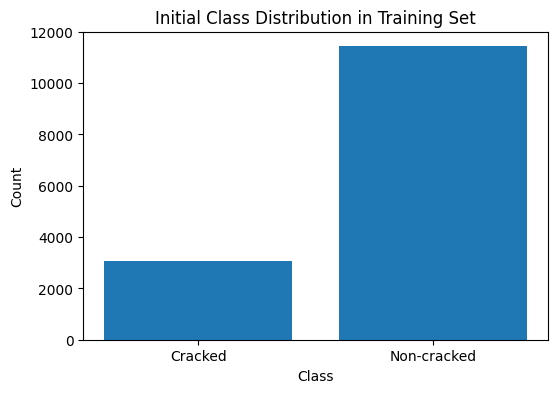

In [37]:
# Plot initial class distribution
plt.figure(figsize=(6, 4))
plt.bar(train_dataset.classes, class_count)
plt.title("Initial Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


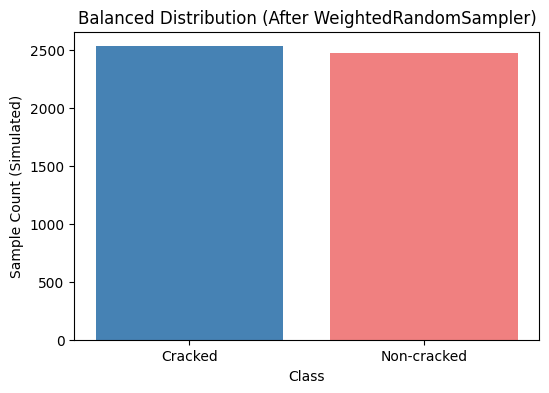

In [38]:
# Visualize how the WeightedRandomSampler changes the sampling
sample_counts = defaultdict(int)

# Number of samples to simulate from the sampler
num_samples_to_check = 5000

# Collect sampled label distribution
for idx in list(sampler)[:num_samples_to_check]:
    label = train_dataset.targets[idx]
    sample_counts[label] += 1

# Convert to lists for plotting
labels_sorted = sorted(sample_counts.keys())
counts_sorted = [sample_counts[l] for l in labels_sorted]

# Get the actual class names from the dataset
class_names = [train_dataset.classes[i] for i in labels_sorted]

# Plot balanced distribution
plt.figure(figsize=(6, 4))
plt.bar(class_names, counts_sorted, color=['steelblue', 'lightcoral']) # Adjusted colors for 2 classes
plt.title("Balanced Distribution (After WeightedRandomSampler)")
plt.xlabel("Class")
plt.ylabel("Sample Count (Simulated)")
plt.show()

In [39]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=1, num_classes=2):
        super(CNN_LSTM, self).__init__()
        self.cnn = models.resnet18(pretrained=True)

        # 1. Freeze all parameters initially
        for param in self.cnn.parameters():
            param.requires_grad = False

        # 2. Unfreeze the last few layers/blocks of ResNet
        # ResNet18 has layers: conv1, layer1, layer2, layer3, layer4, fc
        # layer3 and layer4 typically learn higher-level features
        for param in self.cnn.layer4.parameters(): # Unfreeze the last block
            param.requires_grad = True
        for param in self.cnn.layer3.parameters(): # Unfreeze the second to last block
             param.requires_grad = True

        self.cnn.fc = nn.Identity()  # remove original classification layer

        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        features = features.unsqueeze(1)
        lstm_out, _ = self.lstm(features)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [41]:
print("\nNumber of batches in train_loader:", len(train_loader))
print("Number of batches in test_loader:", len(test_loader))
print("Number of images in training dataset:", len(train_dataset))
print("Number of images in test dataset:", len(test_dataset))
print("Classes:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)



Number of batches in train_loader: 454
Number of batches in test_loader: 114
Number of images in training dataset: 14509
Number of images in test dataset: 3629
Classes: ['Cracked', 'Non-cracked']
Class to index mapping: {'Cracked': 0, 'Non-cracked': 1}


In [ ]:


# --- Initialize metric lists ---
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10

best_val_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()

    # ---- TRAINING ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- VALIDATION ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

     # ---- SAVE BEST MODEL ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with val_loss={val_loss:.4f}")


    # ---- PRINT METRICS ----
    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% | "
          f"Time: {time.time()-start_time:.1f}s")




✅ Best model saved at epoch 1 with val_loss=0.3741
Epoch [1/10]  Train Loss: 0.4360 | Val Loss: 0.3741 | Train Acc: 78.69% | Val Acc: 82.03% | Time: 1237.5s
✅ Best model saved at epoch 2 with val_loss=0.3186
Epoch [2/10]  Train Loss: 0.3736 | Val Loss: 0.3186 | Train Acc: 82.91% | Val Acc: 86.33% | Time: 1263.3s
Epoch [3/10]  Train Loss: 0.3467 | Val Loss: 0.3215 | Train Acc: 84.58% | Val Acc: 85.78% | Time: 1121.6s
Epoch [4/10]  Train Loss: 0.3330 | Val Loss: 0.3296 | Train Acc: 85.20% | Val Acc: 84.90% | Time: 1109.3s
Epoch [5/10]  Train Loss: 0.2986 | Val Loss: 0.3337 | Train Acc: 86.64% | Val Acc: 86.14% | Time: 1185.0s
Epoch [6/10]  Train Loss: 0.2870 | Val Loss: 0.3451 | Train Acc: 87.19% | Val Acc: 87.19% | Time: 1122.7s
Epoch [7/10]  Train Loss: 0.2683 | Val Loss: 0.3260 | Train Acc: 88.32% | Val Acc: 87.52% | Time: 1136.3s
Epoch [8/10]  Train Loss: 0.2444 | Val Loss: 0.4732 | Train Acc: 89.68% | Val Acc: 83.44% | Time: 1152.0s
Epoch [9/10]  Train Loss: 0.2357 | Val Loss: 0.392

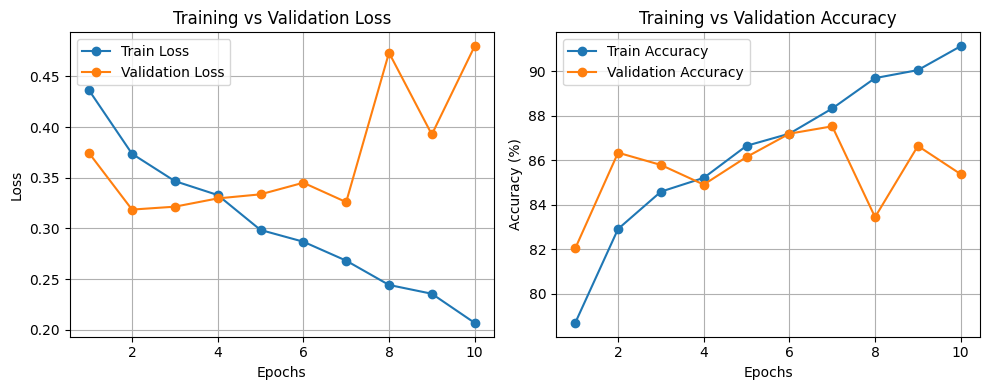

In [43]:
# ---- PLOTTING TRAINING & VALIDATION CURVES ----
plt.figure(figsize=(10, 4))

# ---- Loss Curve ----
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ---- Accuracy Curve ----
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), [a*100 for a in train_accuracies], label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies)+1), [a*100 for a in val_accuracies], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()